# Alignment

By default, `obs_names` and `var_names` are aligned to the leaves of trees stored in `obst` and `vart`. However, {class}`treedata.TreeData` supports multiple alignment types which can be declared using the `alignment` parameter.

* `leaves`: All leaf names must be present in the observation/variable names.
* `nodes`: All leaf and internal node names must be present in the observation/variable names.
* `subset`: A subset of leaf and internal node names are present in the observation/variable names.

This tutorial explains these alignment types and how they effect subset and concatenation behavior.

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import treedata as td
import warnings
import matplotlib.pyplot as plt

warnings.formatwarning = lambda msg, *args, **kwargs: f"{msg}\n"

In [2]:
def plot_tree(tree, color_attr=None):
    """Helper function for plotting trees."""
    plt.figure(figsize=(6, 3))
    node_colors = "lightgrey" if color_attr is None else [tree.nodes[node].get(color_attr) for node in tree.nodes()]
    pos = nx.drawing.nx_agraph.graphviz_layout(tree, prog="dot")
    nx.draw(tree, pos, with_labels=False, node_size=100, node_color=node_colors)
    leaf_nodes = [node for node in tree.nodes() if tree.out_degree(node) == 0]
    for node, (x, y) in pos.items():
        if node in leaf_nodes:
            plt.text(x, y + 10, s=node, rotation=90, fontsize=8, ha="center", va="top")
        else:
            plt.text(x, y, s=node, fontsize=8, ha="center", va="center")
    plt.show()

## Leaf alignment

The `leaves` alignement is intended for experiments where only the leaves of the tree are observed such as CRISPR-based single-cell lineage tracing.

Observations:  ['15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
Alignment:  leaves


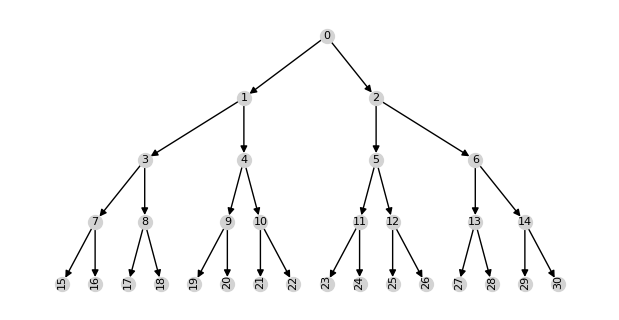

In [24]:
tree = nx.balanced_tree(r=2, h=4, create_using=nx.DiGraph)
tree = nx.relabel_nodes(tree, {i: str(i) for i in tree.nodes()})
leaves = [i for i in tree.nodes if tree.out_degree(i) == 0]
tdata = td.TreeData(obs=pd.DataFrame(index=leaves), obst={"tree": tree})
print("Observations: ", list(tdata.obs_names))
print("Alignment: ", tdata.alignment)
plot_tree(tdata.obst["tree"])

Subsetting yields the tree induced by the selected leaves and their ancestors.

Observations:  ['15', '16', '17', '18', '19', '20', '21', '22']
Alignment:  leaves


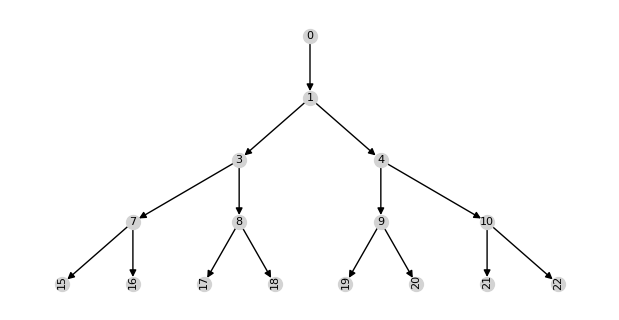

In [25]:
tdata1 = tdata[:8]
tdata2 = tdata[8:]
print("Observations: ", list(tdata1.obs_names))
print("Alignment: ", tdata1.alignment)
plot_tree(tdata1.obst["tree"])

Concatenation yields the tree generated by taking the union of nodes and edges within the listed trees. See the [Concatenation](https://treedata.readthedocs.io/en/latest/notebooks/concatenation.html) tutorial for more details.

Observations:  ['15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
Alignment:  leaves


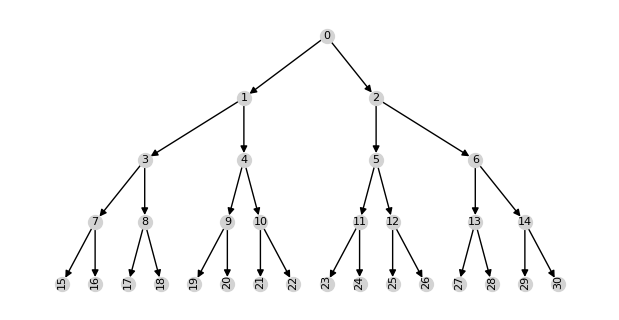

In [26]:
tdata = td.concat([tdata1, tdata2], axis=0)
print("Observations: ", list(tdata.obs_names))
print("Alignment: ", tdata.alignment)
plot_tree(tdata.obst["tree"])

## Node alignment

The `nodes` alignment is designed for experiments were all nodes in the tree are observed such as live-cell imaging.

Observations:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
Alignment:  nodes


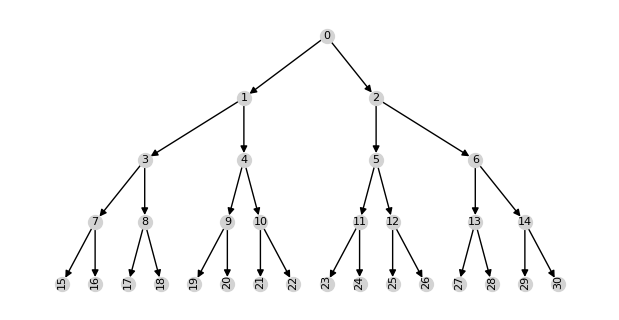

In [28]:
nodes = tree.nodes
tdata = td.TreeData(obs=pd.DataFrame(index=nodes), obst={"tree": tree}, alignment="nodes")
print("Observations: ", list(tdata.obs_names))
print("Alignment: ", tdata.alignment)
plot_tree(tdata.obst["tree"])

Subsetting yields the tree containing the selected nodes as long as that tree is fully connected.

Observations:  ['1', '3', '4', '7', '9', '15', '16', '19', '20']
Alignment:  nodes


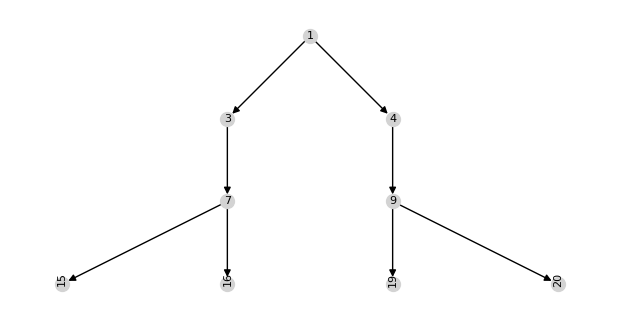

In [29]:
tdata1 = tdata[["1", "3", "4", "7", "9", "15", "16", "19", "20"]]
print("Observations: ", list(tdata1.obs_names))
print("Alignment: ", tdata1.alignment)
plot_tree(tdata1.obst["tree"])

If the subset is not fully connected, subsetting will result in a warning and `tdata` object will be switched to `alignment='subset'`.

One or more trees in `obst` are not disconnected by subsetting. Changing alignment to `subset` and initializing view as actual.


Observations:  ['0', '3', '4', '27']
Alignment:  subset


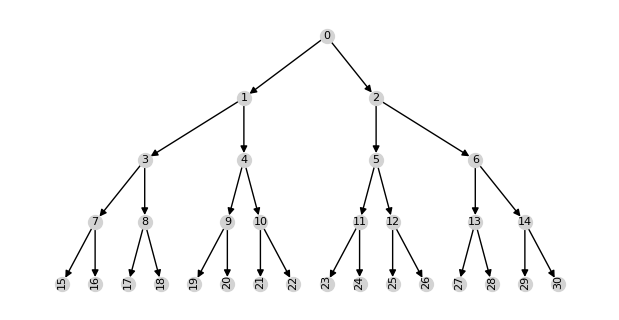

In [30]:
tdata2 = tdata[["0", "3", "4", "27"]]
print("Observations: ", list(tdata2.obs_names))
print("Alignment: ", tdata2.alignment)
plot_tree(tdata2.obst["tree"])

Since a valid tree cannot be generated by concatenating trees with distinct nodes, concatenation will use the specified `merge` strategy to select one of the trees to return.

Observations:  ['1', '3', '4', '7', '9', '15', '16', '19', '20', '0', '2']
Alignment:  nodes


Multiple values found for obst keys: tree. Merging with strategy `first`.


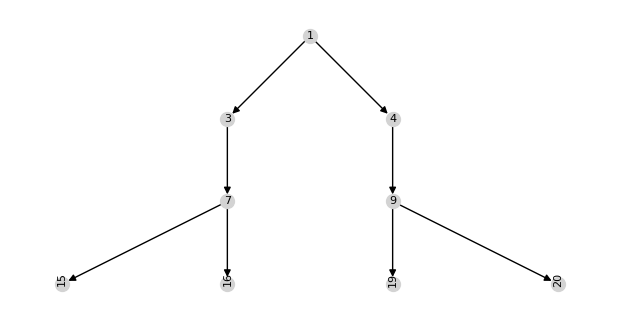

In [ ]:
tdata = td.concat([tdata[["1", "3", "4", "7", "9", "15", "16", "19", "20"]], tdata[["0", "2"]]], axis=0, merge="first")
print("Observations: ", list(tdata.obs_names))
print("Alignment: ", tdata.alignment)
plot_tree(tdata.obst["tree"])

## Subset alignment

The `subset` alignment is the most flexible, allowing for arbitrary subsets of leaves and nodes to be observed.

Observations:  ['25', '28', '15', '17', '30', '5', '26', '3', '29', '27']
Alignment:  subset


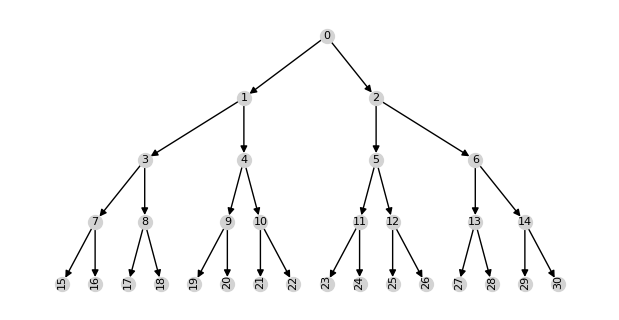

In [43]:
nodes_subset = np.random.choice(list(tree.nodes()), size=10, replace=False)
tdata = td.TreeData(obs=pd.DataFrame(index=nodes_subset), obst={"tree": tree}, alignment="subset")
print("Observations: ", list(tdata.obs_names))
print("Alignment: ", tdata.alignment)
plot_tree(tdata.obst["tree"])

Subsetting does not effect the tree topology

Observations:  ['25', '28', '15', '17']
Alignment:  subset


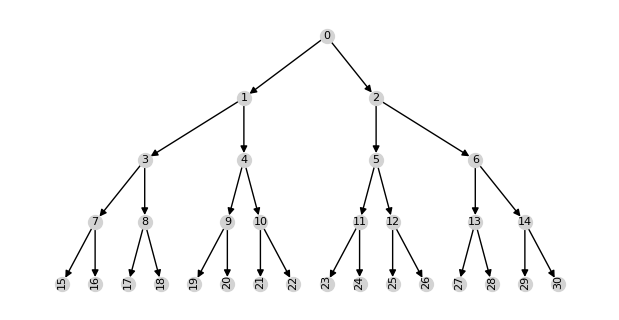

In [45]:
tdata1 = tdata[["25", "28", "15", "17"]]
tdata2 = tdata[["30", "5", "26", "3", "29", "27"]]
print("Observations: ", list(tdata1.obs_names))
print("Alignment: ", tdata1.alignment)
plot_tree(tdata1.obst["tree"])

Similar to the `nodes` alignment, concatenation will use the specified `merge` strategy to select one of the trees to return.

Multiple values found for obst keys: tree. Merging with strategy `first`.


Observations:  ['25', '28', '15', '17', '30', '5', '26', '3', '29', '27']
Alignment:  subset


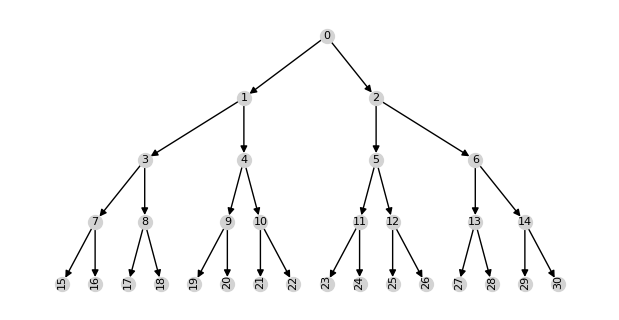

In [46]:
tdata = td.concat([tdata1, tdata2], axis=0, merge="first")
print("Observations: ", list(tdata.obs_names))
print("Alignment: ", tdata.alignment)
plot_tree(tdata.obst["tree"])

## Switching alignment type

The `alignment` type can be changed by setting the `alignment` parameter as long as the alignment is compatible with the observed data.

In [50]:
tdata = td.TreeData(obs=pd.DataFrame(index=leaves), obst={"tree": tree})
print("Observations: ", list(tdata.obs_names))
print("Alignment: ", tdata.alignment)

Observations:  ['15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
Alignment:  leaves


Valid transition:

In [51]:
tdata.alignment = "subset"
print("Observations: ", list(tdata.obs_names))
print("Alignment: ", tdata.alignment)

Observations:  ['15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30']
Alignment:  subset


Invalid transition:

In [53]:
try:
    tdata.alignment = "nodes"
except ValueError as e:
    print(e)
print("Alignment: ", tdata.alignment)

One or more trees in `obst` cannot be transitioned to nodes alignment.
Alignment:  subset
